# Team Based Model

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, MultiTaskLassoCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, LinearSVR
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.multioutput import MultiOutputRegressor

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
import pickle
from src.data.make_team_dataset import clean_team_data
from src.data.make_team_dataset import prep_for_aggregation
from src.data import make_team_dataset
from src.data.make_team_dataset import get_team_and_opp_avg
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features
from src.data.make_betting_dataset import clean_spread_data


In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [12]:
team_data = load_team_data()

In [13]:

clean_team_df = clean_team_data(team_data)

In [14]:
clean_team_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,HOME_GAME
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,0,240,34,74,0.459,2,9,0.222,28,40,0.700,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,0.529,1.00,14.1,0.289,0.667,0.478,18.256,18.9,0.473,0.535,1.0,0.197,98.32,95.5,79.58,95.0,0.446,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.563,0.438,0.000,1.000,0.529,0.471,1
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,1,240,43,88,0.489,6,11,0.545,14,16,0.875,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,0.674,1.81,20.7,0.333,0.711,0.522,16.320,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96.0,0.554,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.622,0.378,1.000,0.000,0.674,0.326,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276,0.698,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.750,0.250,1.000,0.000,0.774,0.226,1
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302,0.724,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.467,0.533,1.000,0.000,0.500,0.500,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,240,36,80,0.450,4,17,0.235,9,13,0.692,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,0.528,1.12,15.6,0.239,NaN,NaN,18.139,18.1,0.475,0.496,1.0,0.199,93.06,94.0,78.33,94.0,0.359,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.469,0.531,1.000,0.000,0.528,0.472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,1,240,35,79,0.443,14,39,0.359,18,21,0.857,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,0.714,1.67,19.5,0.289,0.783,0.538,16.088,16.3,0.532,0.578,1.0,0.200,93.84,92.0,76.67,92.0,0.559,0.506,0.494,0.412,0.078,0.412,0.069,0.176,0.186,0.333,0.619,0.381,0.857,0.143,0.714,0.286,0
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,1,240,38,83,0.458,14,33,0.424,21,22,0.955,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,0.684,2.00,19.7,0.267,0.667,0.467,13.446,14.0,0.542,0.599,1.0,0.199,95.46,93.5,77.92,93.0,0.512,0.602,0.398,0.432,0.144,0.378,0.036,0.189,0.180,0.288,0.542,0.458,0.929,0.071,0.684,0.316,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,0,240,38,82,0.463,14,38,0.368,18,21,0.857,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,0.553,1.40,16.5,0.333,0.733,0.533,15.917,16.0,0.549,0.592,1.0,0.200,95.46,93.5,77.92,94.0,0.488,0.537,0.463,0.444,0.056,0.389,0.231,0.167,0.130,0.389,0.458,0.542,0.714,0.286,0.553,0.447,1
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,0,240,35,79,0.443,10,28,0.357,13,22,0.591,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-

In [15]:
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,1,108,-3,0,240,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,94.0,0.488,6,24,14,42,10,13,9,4
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,1,93,-13,0,240,0,25,51,10,28,13,22,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-10.9,-12.8,93.0,0.456,6,7,14,43,18,7,7,3


In [16]:

matchups = make_team_dataset.create_matchups(ready_for_agg_df)

matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,TEAM_SCORE_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,98,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102678,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,96,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0
102681,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111

In [17]:
avg_data = get_team_and_opp_avg(matchups)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.17it/s]


In [18]:
avg_data

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,115.2,242.5,0.6,28.6,54.6,13.5,38.4,17.5,22.7,9.3,34.0,43.3,25.0,9.3,6.9,15.3,22.7,115.2,1.0,105.67,107.63,103.95,107.11,1.74,0.51,107.0,0.4942,6.1,17.0,21.0,50.7,14.4,13.5,9.8,3.1
51340,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901278,2020-08-07,NOP vs. WAS,1,118,11,1,242.5,0.4,31.7,58.4,11.7,33.7,17.3,25.3,11.7,35.9,47.6,28.3,8.1,3.5,17.5,21.1,115.8,-1.6,106.33,109.58,108.91,110.73,-2.60,-1.14,105.7,0.5030,8.5,14.6,14.7,54.4,17.2,13.6,10.1,0.8,117.4,242.5,0.6,28.8,54.8,13.8,37.3,18.4,23.9,9.2,32.9,42.1,24.9,9.4,6.0,14.5,22.7,117.4,1.6,108.91,110.73,106.33,109.58,2.60,1.14,10

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [19]:
avg_data_2 = add_percentage_features(avg_data)


In [20]:
avg_data_3 = add_rest_days(avg_data_2)
avg_data_3

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,OREB_PCT_team,DREB_PCT_team,REB_PCT_team,TS_PCT_team,EFG_PCT_team,AST_RATIO_team,TOV_PCT_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,0.257642,0.800429,0.531385,0.581348,0.520541,26.547842,14.621324,242.5,0.6,28.6,54.6,1

In [21]:
avg_data_3 = avg_data_3.dropna()
        

In [22]:
avg_data_3

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,OREB_PCT_team,DREB_PCT_team,REB_PCT_team,TS_PCT_team,EFG_PCT_team,AST_RATIO_team,TOV_PCT_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
5,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,7,1,240.0,0.400000,26.800000,59.400000,5.800000,16.200000,23.000000,29.400000,11.800000,27.400000,39.200000,19.000000,8.600000,4.200000,16.600000,22.000000,94.000000,3.200000,100.720000,103.160000,98.420000,99.200000,2.280000,3.940000,91.000000,0.511000,18.000000,7.000000,18.200000,34.600000,14.200000,12.000000,4.600000,1.000000,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.600000,29.600000,62.000000,4.800000,13.200000,17.200000,24.000000,10.200000,28.800000,39.000000,20.400000,6.600000,4.400000,16.600000,23.000000,90.800000,-3.200000,98.420000,99.200000,100.720000,103.160000,-2.280000,-3.940000,91.400000,0.489000,23.200000,7.800000,17.600000,35.200000,15.600000,13.400000,4.400000,0.200000,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0
6,2000-01,22000,1610612745,HOU,Houston Rockets,20000095,2000-11-11,HOU @ POR,0,88,-23,0,240.0,0.500000,26.666667,58.666667,5.666667,15.666667,22.166667,28.500000,11.500000,27.000000,38.500000,19.666667,8.333333,3.833333,17.333333,21.333333,92.500000,3.833333,99.750000,102.066667,97.100000,97.433333,2.633333,4.616667,90.500000,0.524667,18.000000,8.000000,19.000000,34.500000,14.666667,11.333333,4.666667,0.833333,0.289916,0.736364,0.504367,0.573798,0.473094,21.731123,16.633613,240.0,0.500000,29.166667,61.500000,4.666667,12.333333,16.333333,22.333333,9.666667,28.166667,37.833333,19.333333,6.333333,3.833333,17.166667,23.166667,88.666667,-3.833333,97.100000,97.433333,99.750000,102.066667,-2.633333,-4.616667,90.833333,0.475333,23.500000,7.500000,17.000000,34.000000,14.833333,13.666667,4.000000,0.500000,0.263636,0.710084,0.495633,0.562987,0.489842,21.284404,17.025919,2.0
7,2000-01,22000,1610612745,HOU,Houston Rockets,20000098,2000-11-12,HOU @ LAL,0,99,-6,0,240.0,0.428571,27.857143,59.857143,5.142857,15.000000,20.714286,26.428571,10.571429,26.000000,36.571429,19.428571,8.571429,3.571429,16.857143,21.571429,91.857143,0.000000,99.000000,100.857143,99.857143,100.200000,-0.885714,0.642857,91.000000,0.497714,18.571429,7.142857,17.857143,36.285714,14.714286,12.428571,4.285714,0.714286,0.265233,0.748971,0.490421,0.569329,0.475191,21.350078,16.311861,240.0,0.571429,30.142857,61.571429,5.000000,11.857143,16.571429,23.142857,8.714286,29.285714,38.000000,21.000000,6.428571,4.142857,16.857143,22.571429,91.857143,0.000000,99.857143,100.200000,99.000000,100.857143,0.885714,-0.642857,91.428571,0.502286,24.000000,9.285714,17.714286,35.285714,16.142857,13.285714,4.428571,0.428571,0.251029,0.734767,0.509579,0.584928,0.512646,22.968750,16.778523,1.0
8,2000-01,22000,1610612745,HOU,Houston Rockets,20000106,2000-11-14,HOU vs. CHI,1,110,27,1,240.0,0.375000,27.750000,59.750000,5.000000,14.875000,22.250000,28.250000,10.750000,25.750000,36.500000,18.500000,8.375000,3.750

In [23]:
home_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 1]
away_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 0]
away_teams = away_teams.drop(columns = ['GAME_DATE_team',
                                        'SEASON_YEAR_team',
                                        'SEASON_ID_team',
                                        'TEAM_ID_team',
                                        'TEAM_ABBREVIATION_team',
                                        'TEAM_NAME_team',
                                        'GAME_DATE_team',
                                        'MATCHUP_team',
                                        'HOME_GAME_team',
                                        'point_diff_team',
                                        'WL_team'])

full_df = pd.merge(home_teams, away_teams, on='GAME_ID')
full_df = full_df.dropna()

new_cols = []
for col in full_df.columns:
    if col.endswith('_x'):
        col = 'HOME_' + col[:-2]
    if col.endswith('_y'):
        col = 'AWAY_' + col[:-2]
    if col.endswith('_team'):
        col = col[:-5]
        
    new_cols.append(col)
    
full_df.columns = new_cols


columns = full_df.columns.tolist()
columns.remove('AWAY_TEAM_SCORE')
columns.insert(10, 'AWAY_TEAM_SCORE')

full_df = full_df[columns]

In [24]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,78,7,1,240.0,0.400000,26.800000,59.400000,5.800000,16.200000,23.000000,29.400000,11.800000,27.400000,39.200000,19.0,8.600000,4.200000,16.600000,22.000000,94.000000,3.200000,100.720000,103.160,98.420000,99.200000,2.280000,3.940000,91.000000,0.511000,18.000000,7.000000,18.200000,34.600000,14.20,12.000000,4.600000,1.000000,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.600000,29.600000,62.000000,4.800000,13.200000,17.200000,24.000000,10.200000,28.800000,39.000000,20.400000,6.600000,4.400000,16.600000,23.000000,90.800000,-3.200000,98.420000,99.200000,100.720000,103.160,-2.280000,-3.940000,91.400000,0.489000,23.200000,7.800000,17.600000,35.200000,15.600000,13.400000,4.400,0.200000,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.000,0.800000,31.400000,69.800000,3.600000,12.000000,22.400000,30.400000,12.800000,32.400000,45.200000,22.800000,9.800000,3.800000,16.200000,24.000000,96.000000,8.400000,97.460000,99.4800,90.120000,90.340000,7.360000,9.120000,96.600000,0.576000,25.600000,9.800000,20.800000,36.000000,19.000000,11.800000,3.400000,0.200000,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.000,0.200000,30.600000,67.800000,3.600000,13.200000,15.600000,23.000000,13.200000,31.000000,44.200000,18.000000,8.600000,8.000000,19.400000,25.200000,87.600000,-8.400000,90.120000,90.340000,97.460000,99.4800,-7.360000,-9.120000,9

In [26]:
abs(full_df['point_diff']).mean()

10.969488148117398

## Add ELO Rating

In [25]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 100
    home_rating += HOME_AD
    
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    
    if MOV > 0:
        elo_diff = home_rating - away_rating
    else:
        elo_diff = away_rating - home_rating
        
    
    S_home, S_away = get_S(home_score, away_score)
    
    K_home, K_away = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [26]:
def get_elo_ratings(df = full_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION']] = 1300
            df.loc[idx, 'home_rating_i'] = 1300
        else:
            df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION']]

        away_team_abbr = row['MATCHUP'][-3:]
        if away_team_abbr not in elo_dic:
            elo_dic[away_team_abbr] = 1300
            df.loc[idx, 'away_rating_i'] = 1300
        else:
            df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['HOME_TEAM_SCORE']
        away_score = row['AWAY_TEAM_SCORE']
        home_rating = elo_dic[row['TEAM_ABBREVIATION']]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION']] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return None

get_elo_ratings(df = full_df)

progress:: 24089it [00:41, 576.36it/s]


In [27]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,78,7,1,240.0,0.400000,26.800000,59.400000,5.800000,16.200000,23.000000,29.400000,11.800000,27.400000,39.200000,19.0,8.600000,4.200000,16.600000,22.000000,94.000000,3.200000,100.720000,103.160,98.420000,99.200000,2.280000,3.940000,91.000000,0.511000,18.000000,7.000000,18.200000,34.600000,14.20,12.000000,4.600000,1.000000,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.600000,29.600000,62.000000,4.800000,13.200000,17.200000,24.000000,10.200000,28.800000,39.000000,20.400000,6.600000,4.400000,16.600000,23.000000,90.800000,-3.200000,98.420000,99.200000,100.720000,103.160,-2.280000,-3.940000,91.400000,0.489000,23.200000,7.800000,17.600000,35.200000,15.600000,13.400000,4.400,0.200000,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.000,0.800000,31.400000,69.800000,3.600000,12.000000,22.400000,30.400000,12.800000,32.400000,45.200000,22.800000,9.800000,3.800000,16.200000,24.000000,96.000000,8.400000,97.460000,99.4800,90.120000,90.340000,7.360000,9.120000,96.600000,0.576000,25.600000,9.800000,20.800000,36.000000,19.000000,11.800000,3.400000,0.200000,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.000,0.200000,30.600000,67.800000,3.600000,13.200000,15.600000,23.000000,13.200000,31.000000,44.200000,18.000000,8.600000,8.000000,19.400000,25.200

## Add Betting Data

In [28]:

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread

,away_team,home_team,game_date,away_scoreboard,home_scoreboard,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,CHI,MIA,2006-10-31,"22, 37, 21, 28, 108","16, 14, 21, 15, 66",4.5,NaN,4.5,NaN,-4.5,NaN,-4.5,NaN,4.5,-4.5
1,PHX,LAL,2006-10-31,"41, 17, 21, 27, 106","26, 27, 34, 27, 114",-8.5,NaN,-8.0,NaN,8.5,NaN,8.0,NaN,-8.5,8.0
2,ATL,PHI,2006-11-01,"14, 21, 23, 17, 75","29, 20, 24, 15, 88",6.0,NaN,5.5,NaN,-6.0,NaN,-5.5,NaN,5.5,-6.0
3,NOP,BOS,2006-11-01,"26, 28, 21, 16, 91","16, 25, 24, 22, 87",3.5,NaN,3.0,NaN,-3.5,NaN,-3.0,NaN,3.0,-3.5
4,TOR,BKN,2006-11-01,"27, 22, 21, 22, 92","28, 25, 21, 28, 102",7.0,NaN,7.5,NaN,-7.0,NaN,-7.5,NaN,7.0,-7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18327,CHI,DET,2021-03-21,NaN,NaN,-3.0,-3.0,-3.0,-3.0,3.0,3.0,3.0,3.0,-3.0,3.0
18328,TOR,CLE,2021-03-21,NaN,NaN,-7.5,-7.5,-7.5,-7.5,7.5,7.5,7.5,7.5,-7.5,7.5
18329,PHI,NYK,2021-03-21,NaN,NaN,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0
18330,LAL,PHX,2021-03-21,NaN,NaN,10.0,10.0,10.0,10.0,-10.0,-10.0,-10.0,-10.0,10.0,-10.0


## Helper Functions for Bet Simulations

In [29]:
def simulate_bets(selected_bets, unit_size=0.01):
    """This function simulates betting unit_size (default 1%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [30]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [31]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(test_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    spread = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]

    betting_df = pd.merge(full_df[['GAME_DATE', 'TEAM_ABBREVIATION', 'MATCHUP', 'point_diff', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE']], spread, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['TEAM_ABBREVIATION', 'MATCHUP', 'game_date'])
    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'point_diff', 'home_spread_mode']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[test_indices]
    betting_df[['home_score_pred', 'away_score_pred']] = test_preds

    betting_df['point_diff_pred'] = betting_df['home_score_pred'] - betting_df['away_score_pred']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    
    confidence_range = []
    win_percentages = []
    num_games_bet = []
    for i in range(1, 20):
        for j in range(0, i):
            select_bets = betting_df.loc[abs(betting_df['confidence']).between(j, i)]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_range.append((j, i))
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)

    confidence_thresholds = pd.DataFrame({'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('num_games_bet', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    best_thresholds = confidence_thresholds.loc[0, 'confidence_range']
    print("best thresholds:", best_thresholds)
    select_bets = betting_df.loc[abs(betting_df['confidence']).between(best_thresholds[0], best_thresholds[1])]  
    print("num_games_bet:", select_bets.shape[0])
    print("win percetange at threshold:", select_bets['bet_won'].mean())
    
    return select_bets, confidence_thresholds
    



In [32]:
def bet_selector(test_preds, test_indices, low, high):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    spread = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]

    betting_df = pd.merge(full_df[['GAME_DATE', 'TEAM_ABBREVIATION', 'MATCHUP', 'point_diff', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE']], spread, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['TEAM_ABBREVIATION', 'MATCHUP', 'game_date'])
    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'point_diff', 'home_spread_mode']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[test_indices]
    betting_df[['home_score_pred', 'away_score_pred']] = test_preds

    betting_df['point_diff_pred'] = betting_df['home_score_pred'] - betting_df['away_score_pred']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    
    selected_bets = betting_df.loc[abs(betting_df['confidence']).between(low, high)]
    return selected_bets


In [33]:
def train_model():
    features = full_df[['home_rating_i', 'away_rating_i', 'home_elo_pred', 'elo_MOV_pred', 'HOME_rest', 'AWAY_rest', 
                        'HOME_FG3M', 'HOME_FG3M_opp', 'AWAY_FG3M', 'AWAY_FG3M_opp',
                       'HOME_EFG_PCT', 'HOME_EFG_PCT_opp', 'AWAY_EFG_PCT', 'AWAY_EFG_PCT_opp']]
    point_diff = full_df['point_diff']
    win = full_df['WL']
    
    result_dfs = []
    
    for i in range(len(cutoffs)):
        if i == len(cutoffs) - 1:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:, :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:]
        else:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:cutoffs[i+1], :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:cutoffs[i+1]]
        
        pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

        pipeline.fit(X_train, point_diff_train)
        lr_preds = pipeline.predict(X_test)

        mse = mean_squared_error(point_diff_test, lr_preds)
        mae = mean_absolute_error(point_diff_test, lr_preds)
        print("season {}".format(i+2015))
        print("mse:", mse, "mae:", mae)
        print(list(zip(features.columns, pipeline.named_steps['linreg'].coef_)))
        
        if i == len(cutoffs) - 1:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:]
            
        else:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:cutoffs[i+1]]
            
        betting_results['model_preds'] = lr_preds
        betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
        betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
        betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        betting_results['model_spread_diff'] = abs(-betting_results['model_preds'] - betting_results['spread'])
        
        select_bets = betting_results.loc[((betting_results['model_spread_diff'].between(3,6)))
                                 & (abs(betting_results['spread']) < 10)]
        
        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

## Testing Models

In [34]:
full_df = full_df.sort_values('GAME_DATE').reset_index(drop=True)
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,78,7,1,240.0,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.0,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.640065,1300.000000,1305.607497,1300.000000,1294.392503,3.57
1,2000-01,22000,1610612757,POR,Portland Trail Blazers,20000078,2000-11-09,POR vs. DEN,1,107,91,16,1,240.0,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.51

### Creating Feature Dataset

In [35]:
features = full_df.iloc[:, 13:]
features = features.drop(columns=['HOME_MIN', 'HOME_MIN_opp', 'AWAY_MIN', 'AWAY_MIN_opp', 'home_rating_n', 'away_rating_n'])
scores = full_df[['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE']]

cutoff_15 = int(full_df[full_df['SEASON_YEAR'] == '2015-16'].index[0])
cutoff_16 = int(full_df[full_df['SEASON_YEAR'] == '2016-17'].index[0])
cutoff_17 = int(full_df[full_df['SEASON_YEAR'] == '2017-18'].index[0])
cutoff_18 = int(full_df[full_df['SEASON_YEAR'] == '2018-19'].index[0])
cutoff_19 = int(full_df[full_df['SEASON_YEAR'] == '2019-20'].index[0])

cutoffs = [cutoff_15, cutoff_16, cutoff_17, cutoff_18, cutoff_19]

tscv = TimeSeriesSplit()

X_train = features.loc[:cutoff_15]
X_test = features.loc[cutoff_15:]
scores_train = scores.loc[:cutoff_15]
scores_test = scores.loc[cutoff_15:]
test_indices = X_test.index
print(X_train.shape, X_test.shape, scores_train.shape, scores_test.shape)

(18092, 166) (5998, 166) (18092, 2) (5998, 2)


### Linear Regression Pipeline

In [38]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline.fit(X_train, scores_train)
lr_preds = lr_pipeline.predict(X_test)

mse_home = mean_squared_error(scores_test.iloc[:, 0], lr_preds[:, 0])
mse_away = mean_squared_error(scores_test.iloc[:, 1], lr_preds[:, 1])
mae_home = mean_absolute_error(scores_test.iloc[:, 0], lr_preds[:, 0])
mae_away = mean_absolute_error(scores_test.iloc[:, 1], lr_preds[:, 1])
print("mse_home:", mse_home, "mse_away:", mse_away)
print("mae_home:", mae_home, "mae_away:", mae_away)

lr_preds

mse_home: 130.77568619216703 mse_away: 134.58203976004114
mae_home: 9.05287769109207 mae_away: 9.116191531889687


array([[109.20730877, 111.63934044],
       [100.43124347,  97.16333119],
       [102.36861552, 108.81249797],
       ...,
       [110.00123054, 111.96464299],
       [113.68033075, 107.85580107],
       [108.81750434, 112.10917268]])

In [39]:
lr_pipeline.fit(features, scores)

Pipeline(steps=[('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [40]:
# Save the Model to file
filename = "../models/linreg_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(lr_pipeline, file)
    


best thresholds: (6, 10)
num_games_bet: 549
win percetange at threshold: 0.5336976320582878


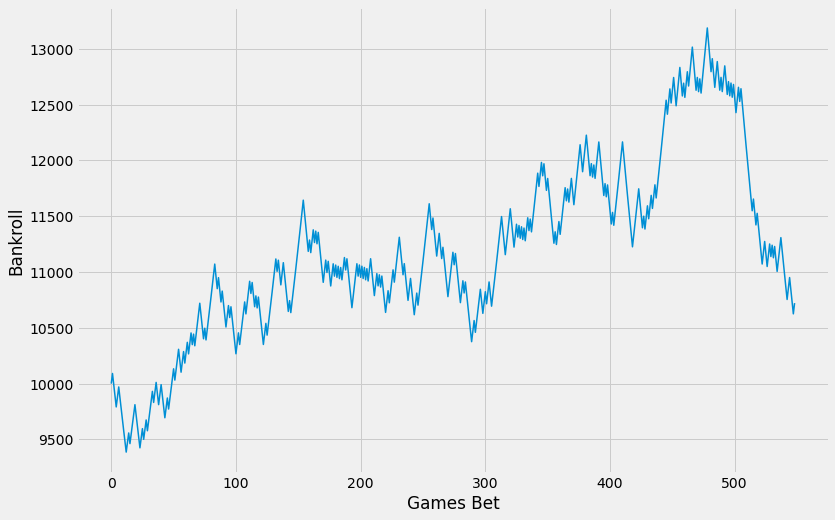

min balance: 9386.58532451765 
max balance: 13186.190930163153 
final balance: 10818.96834503915 
win percentage 53.37


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18092,2015-11-05,POR,MEM,115,96,19,4.5,1.0,100.431243,97.163331,3.267912,1,1,7.767912,10000.000000,100.000000,10090.909091
1,18098,2015-11-07,LAC,HOU,105,109,-4,-5.5,0.0,114.924108,103.388470,11.535637,1,0,6.035637,10090.909091,100.909091,9990.000000
2,18121,2015-11-10,NOP,DAL,120,105,15,-3.0,1.0,102.519680,105.804152,-3.284472,0,0,-6.284472,9990.000000,99.900000,9890.100000
3,18136,2015-11-12,PHX,LAC,118,104,14,-2.5,1.0,102.542722,109.935846,-7.393124,0,0,-9.893124,9890.100000,98.901000,9791.199000
4,18148,2015-11-13,MEM,POR,101,100,1,-6.5,0.0,99.797126,100.784108,-0.986982,0,1,-7.486982,9791.199000,97.911990,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,24062,2020-09-08,HOU,LAL,102,112,-10,4.5,0.0,113.125960,110.462251,2.663709,1,0,7.163709,10950.140184,109.501402,10840.638782
545,24065,2020-09-09,DEN,LAC,85,96,-11,8.0,0.0,112.766838,114.229684,-1.462846,1,0,6.537154,10840.638782,108.406388,10732.232394
546,24066,2020-09-10,HOU,LAL,100,110,-10,5.5,0.0,111.550235,110.229986,1.320249,1,0,6.820249,10732.232394,107.322324,10624.910070
547,24070,2020-09-13,DEN,LAC,111,98,13,8.5,1.0,108.145295,110.444804,-2.299509,1,1,6.200491,10624.910070,106.249101,10721.500162


In [41]:
select_bets_lr, best_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)

#### RFE for Linear Regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:


lr_rfe = RFECV(estimator = LinearRegression(), cv=tscv, n_jobs=-1, verbose=1)
lr_rfe.fit(X_train_scaled, scores_train)

feature_mask = lr_rfe.support_
lr_reduced = lr_rfe.estimator_

X_test_reduced = X_test_scaled[:, feature_mask]

lr_reduced.fit(X_test_reduced, scores_test)
lr_reduced_preds = lr_reduced.predict(X_test_reduced)


In [ ]:
features = X_train.iloc[:, feature_mask].columns
coefficients = lr_reduced.coef_[0]
coefficients.shape
coefs = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coefs.sort_values('coefficient').plot('barh')

In [ ]:
select_bets_lr_re, best_thresholds_lr_re = find_optimal_threshold(lr_reduced_preds, test_indices)
simulate_bets(select_bets_lr_re)

In [ ]:
select_bets = bet_selector(lr_reduced_preds, test_indices, 5, 15)
select_bets
simulate_bets(select_bets)

### Elastic Net Pipeline

In [ ]:
pipeline_en = Pipeline([('scaler', StandardScaler()),
                    ('en', ElasticNet(max_iter=5000))])

params = {'en__alpha':np.logspace(-1, 2, 10),
         'en__l1_ratio':np.linspace(0.05, 1, 20)}


en_gs = GridSearchCV(pipeline_en, param_grid=params, n_jobs=-1, cv=tscv, verbose=1)
en_gs.fit(X_train, scores_train)

print("best estimator:", en_gs.best_estimator_)
print("best parameters:", en_gs.best_params_)
best_en = en_gs.best_estimator_
en_preds = best_en.predict(X_test)

In [ ]:
best_en = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.1, l1_ratio=1.0, max_iter=5000))])


best_en.fit(X_train, scores_train)
best_en.predict(X_train, scores_train)

In [ ]:
select_bets_en, best_thresholds_en = find_optimal_threshold(en_preds, test_indices)
simulate_bets(select_bets_en)

### Lasso Regression

In [ ]:
lasso_cv = MultiTaskLassoCV(cv = tscv)

lasso_cv.fit(X_train_scaled, scores_train)

best_alpha = lasso_cv.alpha_
print(best_alpha)

In [66]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])

pipeline_lasso.fit(X_train, scores_train)
lasso_preds = pipeline_lasso.predict(X_test)


best thresholds: (6, 19)
num_games_bet: 494
win percetange at threshold: 0.5404858299595142


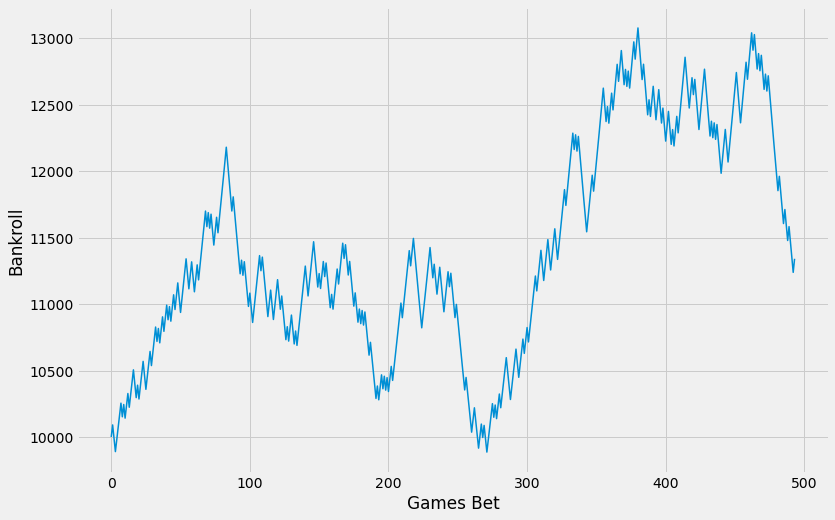

min balance: 9886.482417290192 
max balance: 13077.512375409031 
final balance: 11443.992708794616 
win percentage 54.05


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18092,2015-11-05,POR,MEM,115,96,19,4.5,1.0,104.066036,97.233957,6.832079,1,1,11.332079,10000.000000,100.000000,10090.909091
1,18113,2015-11-09,PHI,CHI,88,111,-23,10.5,0.0,99.018939,103.455576,-4.436638,1,0,6.063362,10090.909091,100.909091,9990.000000
2,18118,2015-11-10,WAS,OKC,101,125,-24,6.5,0.0,110.150680,110.453053,-0.302373,1,0,6.197627,9990.000000,99.900000,9890.100000
3,18134,2015-11-11,DAL,LAC,118,108,10,7.0,1.0,105.121915,104.577941,0.543974,1,1,7.543974,9890.100000,98.901000,9980.010000
4,18148,2015-11-13,MEM,POR,101,100,1,-6.5,0.0,98.061141,100.962561,-2.901420,0,1,-9.401420,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,24062,2020-09-08,HOU,LAL,102,112,-10,4.5,0.0,113.955178,110.154170,3.801008,1,0,8.301008,11582.742497,115.827425,11466.915072
490,24063,2020-09-08,MIL,MIA,94,103,-9,5.5,0.0,112.235826,107.361505,4.874321,1,0,10.374321,11466.915072,114.669151,11352.245921
491,24066,2020-09-10,HOU,LAL,100,110,-10,5.5,0.0,112.584521,109.194748,3.389773,1,0,8.889773,11352.245921,113.522459,11238.723462
492,24085,2020-10-04,MIA,LAL,115,104,11,9.5,1.0,108.725046,110.760970,-2.035924,1,1,7.464076,11238.723462,112.387235,11340.893675


In [67]:
select_bets_lasso, best_thresholds_lasso = find_optimal_threshold(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

In [ ]:
feature_names = X_train.columns
coefs = pipeline_lasso.named_steps['lasso'].coef_[0]

coef_df = pd.DataFrame({'feature_name':feature_names, 'coefficient':coefs})
coef_df.sort_values('coefficient').loc[coef_df['coefficient'] != 0]
non_zero_features = coef_df.loc[coef_df['coefficient'] != 0, 'feature_name'].tolist()
non_zero_features

In [ ]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])

pipeline_lasso.fit(features, scores)

filename = '../models/best_lasso.pkl'
pickle.dump(pipeline_lasso, open(filename, 'wb'))

### Linear SVR Pipeline

best thresholds: (5, 12)
num_games_bet: 1072
win percetange at threshold: 0.5307835820895522


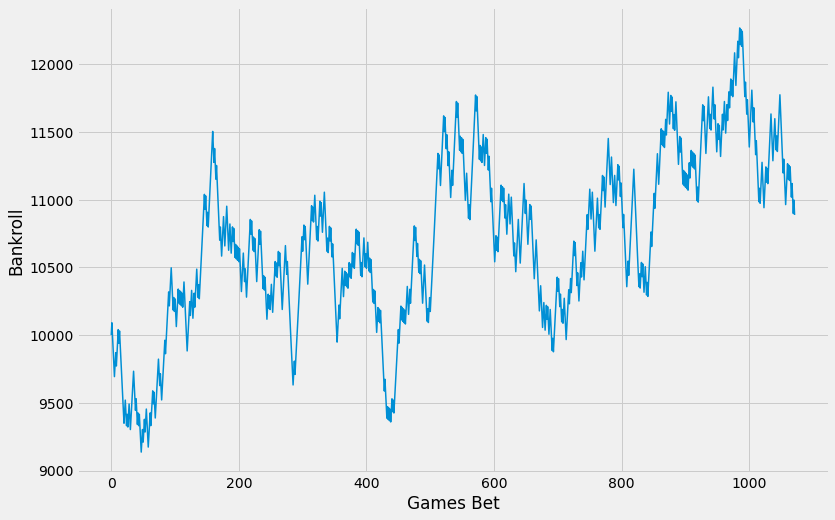

min balance: 9136.000753118973 
max balance: 12268.008435258334 
final balance: 10986.009168871979 
win percentage 53.080000000000005


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18092,2015-11-05,POR,MEM,115,96,19,4.5,1.0,100.001495,96.630543,3.370953,1,1,7.870953,10000.000000,100.000000,10090.909091
1,18094,2015-11-06,SAC,HOU,110,116,-6,4.5,0.0,106.902224,106.346962,0.555262,1,0,5.055262,10090.909091,100.909091,9990.000000
2,18098,2015-11-07,LAC,HOU,105,109,-4,-5.5,0.0,114.254508,103.073933,11.180575,1,0,5.680575,9990.000000,99.900000,9890.100000
3,18105,2015-11-07,SAS,CHA,114,94,20,-9.5,1.0,96.691327,94.225984,2.465344,0,0,-7.034656,9890.100000,98.901000,9791.199000
4,18121,2015-11-10,NOP,DAL,120,105,15,-3.0,1.0,102.946059,105.864670,-2.918612,0,0,-5.918612,9791.199000,97.911990,9693.287010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,24065,2020-09-09,DEN,LAC,85,96,-11,8.0,0.0,112.262993,111.626647,0.636346,1,0,8.636346,11119.206252,111.192063,11008.014189
1068,24066,2020-09-10,HOU,LAL,100,110,-10,5.5,0.0,110.627466,108.384842,2.242624,1,0,7.742624,11008.014189,110.080142,10897.934047
1069,24070,2020-09-13,DEN,LAC,111,98,13,8.5,1.0,107.561779,108.751738,-1.189959,1,1,7.310041,10897.934047,108.979340,10997.006175
1070,24080,2020-09-25,BOS,MIA,121,108,13,-3.5,1.0,104.254309,106.290555,-2.036246,0,0,-5.536246,10997.006175,109.970062,10887.036113


In [44]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', MultiOutputRegressor(LinearSVR(max_iter=5000)))])

pipeline_svr.fit(X_train, scores_train)

svr_preds = pipeline_svr.predict(X_test)

select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

In [45]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', MultiOutputRegressor(LinearSVR(max_iter=5000)))])

search_spaces = {'svr__estimator__C': Real(1e-3, 1e+4, prior='log-uniform'),
                'svr__estimator__loss': Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs = BayesSearchCV(pipeline_svr, n_iter=25, search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=1)
svr_bs.fit(X_train, scores_train)

print("best estimator:", svr_bs.best_estimator_)
print("best parameters:", svr_bs.best_params_)
best_svr = svr_bs.best_estimator_
svr_preds = best_svr.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.05679521553930955,
                                                          loss='squared_epsilon_insensitive',
                                                          max_iter=5000)))])
best parameters: OrderedDict([('svr__estimator__C', 0.05679521553930955), ('svr__estimator__loss', 'squared_epsilon_insensitive')])


best thresholds: (6, 19)
num_games_bet: 566
win percetange at threshold: 0.5318021201413428


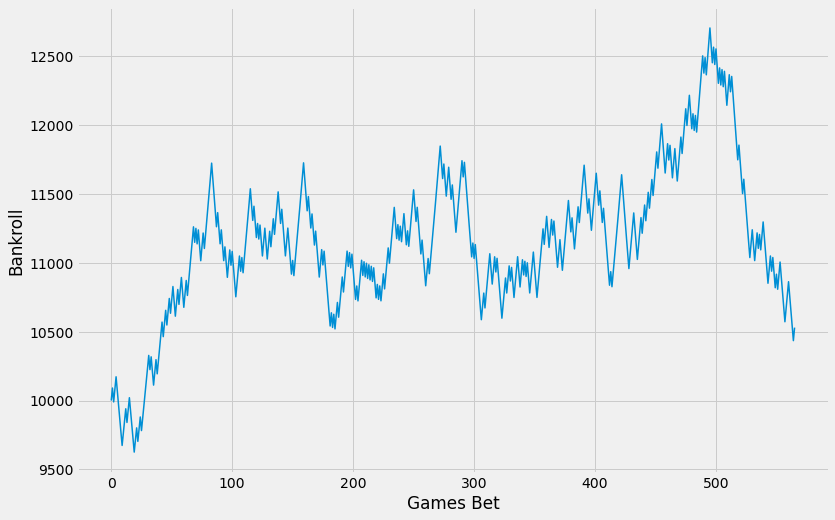

min balance: 9625.637221031226 
max balance: 12705.254276376681 
final balance: 10625.391735044148 
win percentage 53.18000000000001


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18092,2015-11-05,POR,MEM,115,96,19,4.5,1.0,100.973652,96.929922,4.043730,1,1,8.543730,10000.000000,100.000000,10090.909091
1,18136,2015-11-12,PHX,LAC,118,104,14,-2.5,1.0,102.515238,108.523490,-6.008252,0,0,-8.508252,10090.909091,100.909091,9990.000000
2,18148,2015-11-13,MEM,POR,101,100,1,-6.5,0.0,99.487273,100.216906,-0.729634,0,1,-7.229634,9990.000000,99.900000,10080.818182
3,18149,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,104.457542,104.009489,0.448053,1,1,6.948053,10080.818182,100.808182,10172.461983
4,18169,2015-11-16,MEM,OKC,122,114,8,-2.5,1.0,99.754100,104.969308,-5.215207,0,0,-7.715207,10172.461983,101.724620,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,24063,2020-09-08,MIL,MIA,94,103,-9,5.5,0.0,110.126400,105.188863,4.937538,1,0,10.437538,10754.216603,107.542166,10646.674437
562,24065,2020-09-09,DEN,LAC,85,96,-11,8.0,0.0,112.395593,113.464835,-1.069242,1,0,6.930758,10646.674437,106.466744,10540.207693
563,24066,2020-09-10,HOU,LAL,100,110,-10,5.5,0.0,111.410321,109.930839,1.479481,1,0,6.979481,10540.207693,105.402077,10434.805616
564,24070,2020-09-13,DEN,LAC,111,98,13,8.5,1.0,107.640850,109.843551,-2.202701,1,1,6.297299,10434.805616,104.348056,10529.667485


In [49]:
select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

In [52]:
best_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.05679521553930955,
                                                          loss='squared_epsilon_insensitive',
                                                          max_iter=5000)))])

best_svr.fit(features, scores)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.05679521553930955,
                                                          loss='squared_epsilon_insensitive',
                                                          max_iter=5000)))])

In [53]:
# Save the Model to file
filename = "../models/svr_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_svr, file)
    


Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.05679521553930955,
                                                          loss='squared_epsilon_insensitive',
                                                          max_iter=5000)))])

### Random Forest

In [173]:
search_spaces = {'max_depth': Integer(2, 30),
              'min_samples_split': Real(0.01, 0.99),
                 'max_features':Real(0.1, 0.99),
                 'min_samples_leaf':Real(0.01, 0.5)
                }  

rf_bscv = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_iter=50, cv=tscv, verbose=1, n_jobs=-1)

rf_bscv.fit(X_train, scores_train)


best_rf = rf_bscv.best_estimator_
print(best_rf)

best_rf.fit(X_train, scores_train)

rf_preds = best_rf.predict(X_test)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.3s finished


RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)


In [63]:
best_rf = RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)
best_rf.fit(X_train, scores_train)

rf_preds = best_rf.predict(X_test)

In [94]:
best_rf.fit(features, scores)

RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)

In [95]:
# Save the Model to file
filename = "../models/rf_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_rf, file)
    


best thresholds: (4, 5)
num_games_bet: 575
win percetange at threshold: 0.5321739130434783


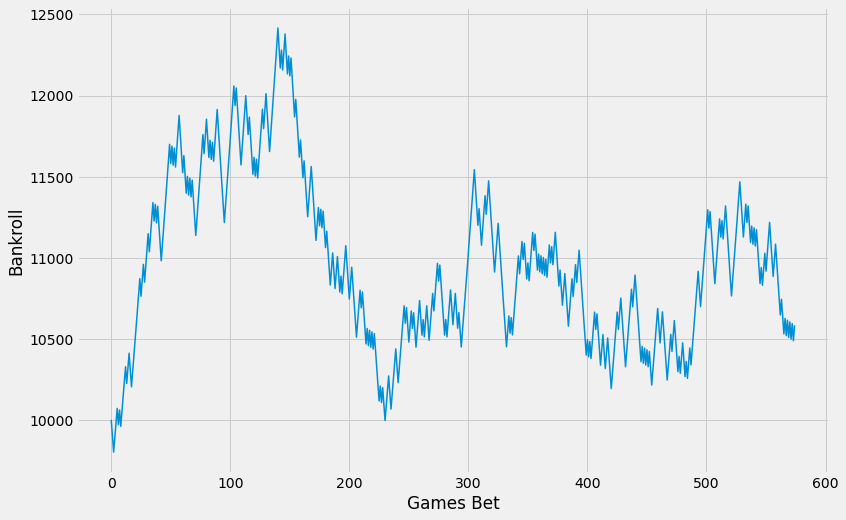

min balance: 9801.0 
max balance: 12416.827886793935 
final balance: 10679.162549581277 
win percentage 53.22


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18112,2015-11-09,GSW,DET,109,95,14,-12.5,1.0,104.738545,96.966817,7.771728,0,0,-4.728272,10000.000000,100.000000,9900.000000
1,18120,2015-11-10,MIA,LAL,101,88,13,-11.0,1.0,103.895754,96.942360,6.953395,0,0,-4.046605,9900.000000,99.000000,9801.000000
2,18125,2015-11-11,HOU,BKN,98,106,-8,-11.5,0.0,107.792015,100.948626,6.843389,0,1,-4.656611,9801.000000,98.010000,9890.100000
3,18139,2015-11-13,NYK,CLE,84,90,-6,7.0,1.0,100.203467,102.643792,-2.440325,1,1,4.559675,9890.100000,98.901000,9980.010000
4,18148,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,102.083858,103.836392,-1.752535,1,1,4.747465,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,24053,2020-09-03,LAC,DEN,120,97,23,-9.5,1.0,110.210411,105.375897,4.834515,0,0,-4.665485,10604.151577,106.041516,10498.110061
571,24056,2020-09-05,LAC,DEN,101,110,-9,-9.0,0.0,110.460376,105.463654,4.996722,0,1,-4.003278,10498.110061,104.981101,10593.547425
572,24074,2020-09-18,LAL,DEN,126,114,12,-7.5,1.0,106.956299,104.343853,2.612445,0,0,-4.887555,10593.547425,105.935474,10487.611951
573,24076,2020-09-20,LAL,DEN,105,103,2,-7.5,0.0,107.963541,104.892835,3.070707,0,1,-4.429293,10487.611951,104.876120,10582.953878


In [175]:
select_bets_rf, best_thresholds_rf = find_optimal_threshold(rf_preds, test_indices)
simulate_bets(select_bets_rf)

In [176]:
best_thresholds_rf

,index,confidence_range,num_games_bet,win_percentage
0,14,"(4, 5)",575,0.532174
1,65,"(10, 11)",120,0.533333
2,134,"(14, 16)",28,0.535714
3,135,"(15, 16)",11,0.545455


### XGB

In [180]:
search_spaces = {'estimator__min_child_weight':Integer(1,8),
              'estimator__gamma': Real(0.5, 3),
              'estimator__subsample': Real(0.6, 1),
              'estimator__colsample_bytree': Real(0.5, 1),
              'estimator__max_depth': Integer(3, 30),
              'estimator__reg_lambda': Integer(1, 10),
              'estimator__reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(MultiOutputRegressor(xgb.XGBRegressor()), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

xgb_bs.fit(X_train, scores_train)

print(xgb_bs.best_estimator_)

best_xgb = xgb_bs.best_estimator_
xgb_preds = best_xgb.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, gamma=0.5,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=6, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=10,
                                            reg_

In [106]:
best_xgb = MultiOutputRegressor(estimator=xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.5,
                                            importance_type='gain', max_depth=3,
                                            min_child_weight=6,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=10,
                                            reg_lambda=10))
best_xgb.fit(features, scores)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, gamma=0.5,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=6, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=10,
                                            reg_

In [107]:
# Save the Model to file
filename = "../models/xgb_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_xgb, file)
    
# Load the Model back from file
with open(filename, 'rb') as file:  
    best_xgb = pickle.load(file)

best_xgb

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, gamma=0.5,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=6, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=10,
                                            reg_

best thresholds: (11, 13)
num_games_bet: 236
win percetange at threshold: 0.5338983050847458


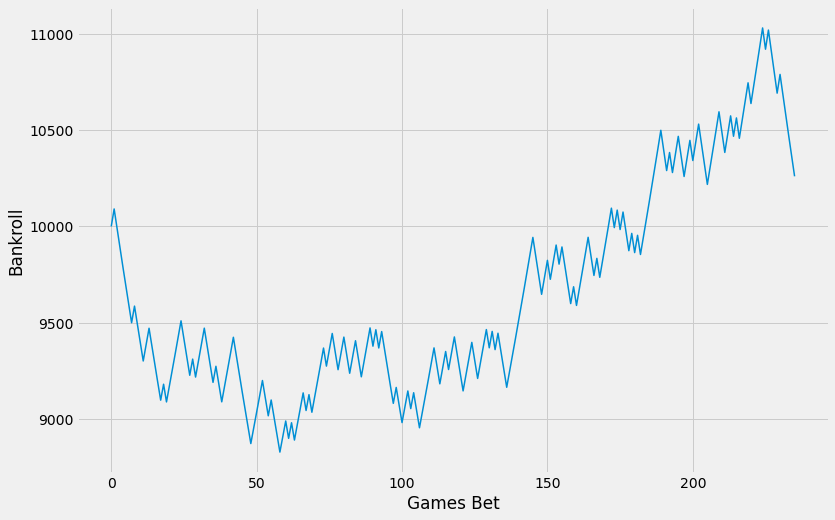

min balance: 8829.246937636215 
max balance: 11030.133546256506 
final balance: 10353.528967276114 
win percentage 53.39


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18148,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,107.867104,102.802269,5.064835,1,1,11.564835,10000.000000,100.000000,10090.909091
1,18190,2015-11-20,DEN,PHX,107,114,-7,3.0,0.0,107.781609,99.109589,8.672020,1,0,11.672020,10090.909091,100.909091,9990.000000
2,18262,2015-11-29,TOR,PHX,102,107,-5,-3.0,0.0,112.053307,97.325027,14.728279,1,0,11.728279,9990.000000,99.900000,9890.100000
3,18268,2015-11-30,MIL,DEN,92,74,18,-4.0,1.0,93.772675,100.842636,-7.069962,0,0,-11.069962,9890.100000,98.901000,9791.199000
4,18343,2015-12-10,BKN,PHI,100,91,9,-7.0,1.0,90.809036,96.231415,-5.422379,0,0,-12.422379,9791.199000,97.911990,9693.287010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,24009,2020-08-17,BOS,PHI,109,101,8,-6.5,1.0,98.999809,103.738457,-4.738647,0,0,-11.238647,10681.133197,106.811332,10574.321865
232,24015,2020-08-19,BOS,PHI,128,101,27,-4.5,1.0,96.721703,103.466515,-6.744812,0,0,-11.244812,10574.321865,105.743219,10468.578647
233,24028,2020-08-22,ORL,MIL,107,121,-14,12.5,0.0,113.059914,114.500946,-1.441032,1,0,11.058968,10468.578647,104.685786,10363.892860
234,24039,2020-08-25,LAC,DAL,154,111,43,-8.5,1.0,106.753502,110.046539,-3.293037,0,0,-11.793037,10363.892860,103.638929,10260.253932


In [181]:
select_bets_xgb, best_thresholds_xgb = find_optimal_threshold(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

### ADABoost

In [102]:
ada = MultiOutputRegressor(AdaBoostRegressor())

search_spaces = {'estimator__learning_rate': Real(0.01,1, prior='log-uniform'),
                'estimator__loss': Categorical(['linear', 'square', 'exponential']), 
                'estimator__n_estimators': Integer(50, 500)}

ada_gs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=25, cv=tscv, n_jobs=-1, verbose=1)
ada_gs.fit(X_train, scores_train)


best_ada = ada_gs.best_estimator_
print(ada_gs.best_params_)
print(best_ada)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min finished


OrderedDict([('estimator__learning_rate', 0.0523178495129621), ('estimator__loss', 'exponential'), ('estimator__n_estimators', 373)])
MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.0523178495129621,
                                                 loss='exponential',
                                                 n_estimators=373))


best_ada: 


best thresholds: (7, 8)
num_games_bet: 348
win percetange at threshold: 0.5517241379310345


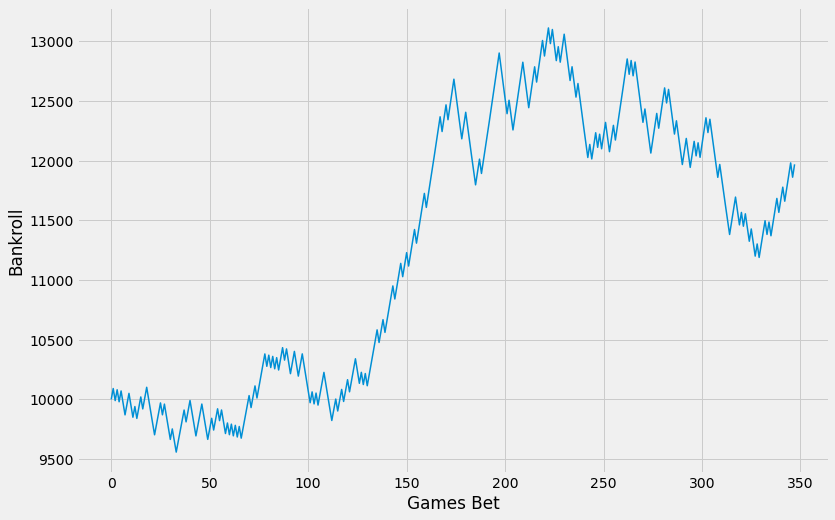

min balance: 9558.45956230504 
max balance: 13112.067421987285 
final balance: 11849.6830415164 
win percentage 55.169999999999995


,index,confidence_range,num_games_bet,win_percentage
0,35,"(7, 8)",348,0.551724
1,148,"(12, 17)",75,0.546667
2,165,"(12, 18)",75,0.546667
3,183,"(12, 19)",75,0.546667
4,132,"(12, 16)",73,0.534247
5,149,"(13, 17)",36,0.611111
6,184,"(13, 19)",36,0.611111
7,166,"(13, 18)",36,0.611111
8,133,"(13, 16)",34,0.588235
9,118,"(13, 15)",33,0.575758


In [104]:
ada_preds = best_ada.predict(X_test)
select_bets_ada, best_thresholds_ada= find_optimal_threshold(ada_preds, test_indices)
simulate_bets(select_bets_ada)
best_thresholds_ada

In [248]:
final_ada = MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.0523178495129621,
                                                 loss='exponential',
                                                 n_estimators=373))

final_ada.fit(features, scores)

MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.0523178495129621,
                                                 loss='exponential',
                                                 n_estimators=373))

<AxesSubplot:ylabel='feature'>

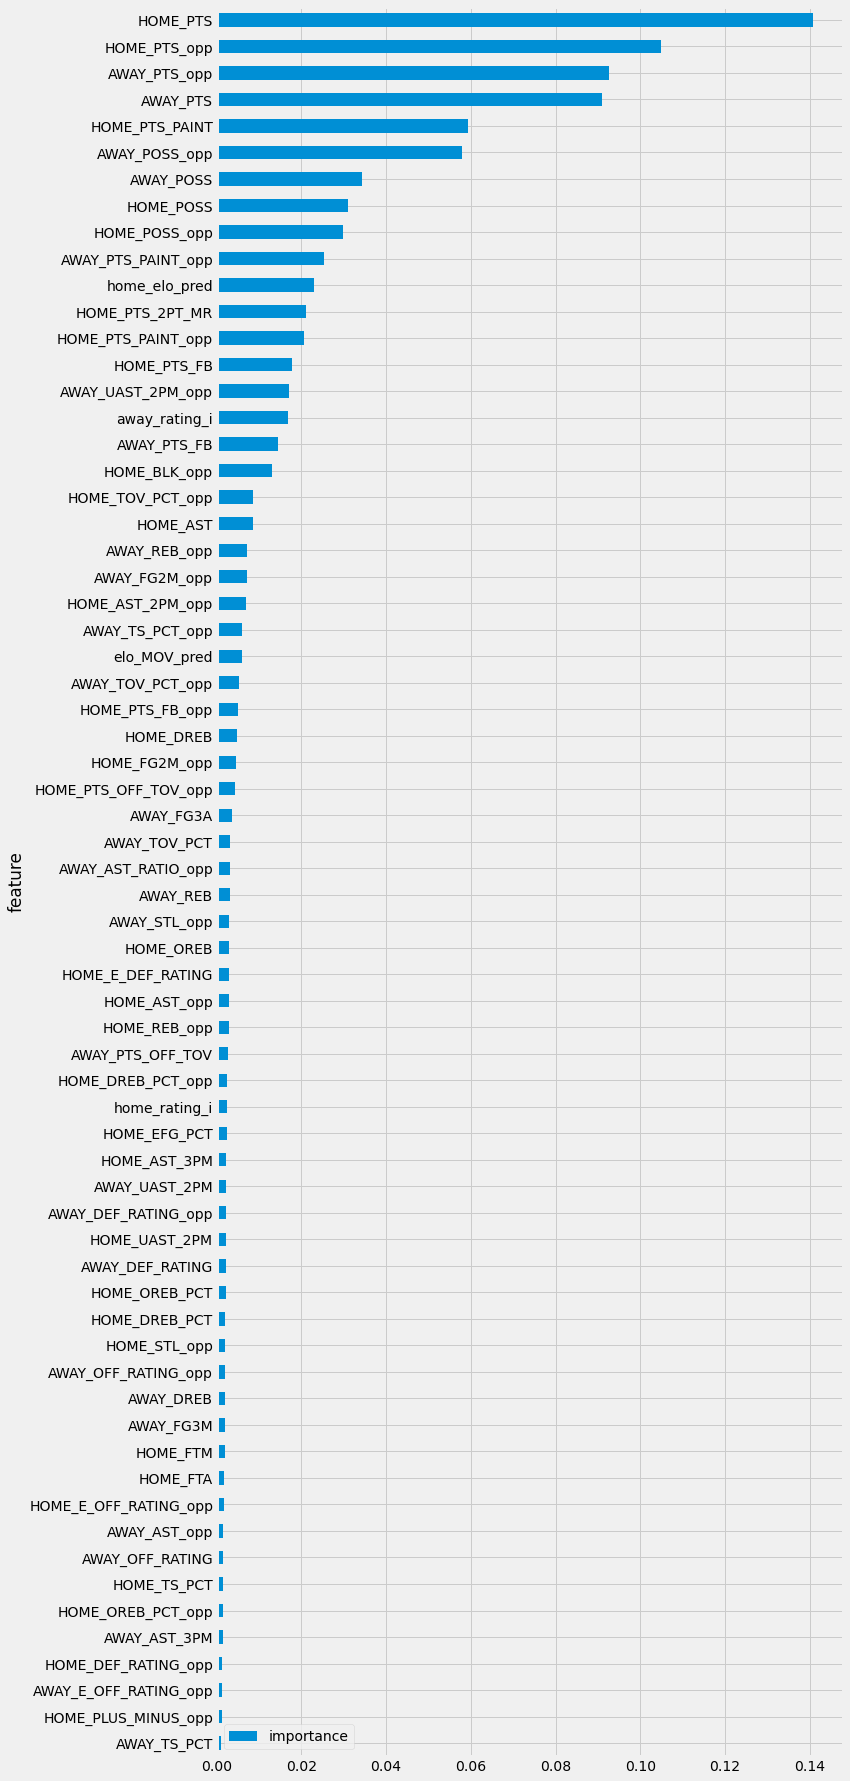

In [267]:
feat_impts = []
for clf in final_ada.estimators_:
    feat_impts.append(clf.feature_importances_)
    
feature_names = features.columns
feat_importances = np.mean(feat_impts, axis=0)

feat_importances = pd.DataFrame({"feature":feature_names, 
             "importance":feat_importances})

feat_importances = feat_importances.sort_values('importance')
feat_importances.iloc[100:].plot(kind='barh', x='feature', figsize=(10,30))



In [109]:
# Save the Model to file
filename = "../models/ada_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(final_ada, file)
    
# Load the Model back from file
with open(filename, 'rb') as file:  
    final_ada = pickle.load(file)



In [57]:
ada_lasso = MultiOutputRegressor(AdaBoostRegressor(base_estimator = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])))

ada_lasso.fit(X_train, scores_train)

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=Pipeline(steps=[('scaler',
                                                                                 StandardScaler()),
                                                                                ('lasso',
                                                                                 Lasso(alpha=0.18149))])))

best thresholds: (7, 18)
num_games_bet: 286
win percetange at threshold: 0.5524475524475524


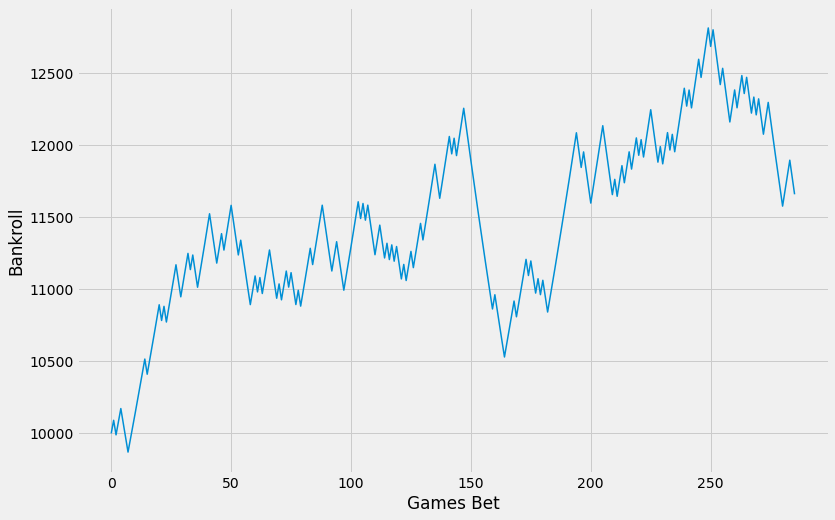

min balance: 9870.3296901 
max balance: 12813.203250606675 
final balance: 11542.27192815394 
win percentage 55.24


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18092,2015-11-05,POR,MEM,115,96,19,4.5,1.0,103.264773,97.352179,5.912594,1,1,10.412594,10000.000000,100.000000,10090.909091
1,18094,2015-11-06,SAC,HOU,110,116,-6,4.5,0.0,111.468497,108.903755,2.564742,1,0,7.064742,10090.909091,100.909091,9990.000000
2,18148,2015-11-13,MEM,POR,101,100,1,-6.5,0.0,99.034297,101.613523,-2.579226,0,1,-9.079226,9990.000000,99.900000,10080.818182
3,18149,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,107.213267,105.670979,1.542289,1,1,8.042289,10080.818182,100.808182,10172.461983
4,18169,2015-11-16,MEM,OKC,122,114,8,-2.5,1.0,100.755049,105.269377,-4.514329,0,0,-7.014329,10172.461983,101.724620,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,24042,2020-08-29,MIL,ORL,118,104,14,-14.5,0.0,120.667780,113.869374,6.798406,0,1,-7.701594,11682.213278,116.822133,11788.415217
282,24060,2020-09-07,DEN,LAC,107,113,-6,9.0,1.0,112.204720,113.939587,-1.734867,1,1,7.265133,11788.415217,117.884152,11895.582628
283,24062,2020-09-08,HOU,LAL,102,112,-10,4.5,0.0,114.758994,109.786724,4.972271,1,0,9.472271,11895.582628,118.955826,11776.626802
284,24063,2020-09-08,MIL,MIA,94,103,-9,5.5,0.0,112.030707,107.581704,4.449002,1,0,9.949002,11776.626802,117.766268,11658.860533


In [58]:
ada_lasso_preds = ada_lasso.predict(X_test)
select_bets_ada_lasso, best_thresholds_ada_lasso= find_optimal_threshold(ada_lasso_preds, test_indices)
simulate_bets(select_bets_ada_lasso)


In [153]:
import lightgbm as lgb

lgbr = lgb.LGBMRegressor()

search_spaces = {'estimator__min_child_weight':Integer(1,8),
              'estimator__subsample': Real(0.6, 1),
              'estimator__colsample_bytree': Real(0.5, 1),
              'estimator__max_depth': Integer(3, 30),
              'estimator__reg_lambda': Integer(1, 10),
              'estimator__reg_alpha': Integer(0, 10),
                'estimator__boosting_type':Categorical(['gbdt'], transform='string'),
                'estimator__num_leaf':Integer(1, 4096),
                'estimator__feature_fraction':Real(0.01, 1)}
    
    
lgbr_bs = BayesSearchCV(MultiOutputRegressor(lgb.LGBMRegressor(objective='regression', subsample_freq=1)), n_iter=100, search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs.fit(X_train, scores_train)

best_lgbr = lgbr_bs.best_estimator_


lgbr_preds = best_lgbr.predict(X_test)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


[LightGBM] [Warning] feature_fraction is set=0.09266836113965404, colsample_bytree=0.7603922042290461 will be ignored. Current value: feature_fraction=0.09266836113965404
[LightGBM] [Warning] num_leaves is set=31, num_leaf=31 will be ignored. Current value: num_leaves=31


best thresholds: (7, 17)
num_games_bet: 603
win percetange at threshold: 0.5306799336650083


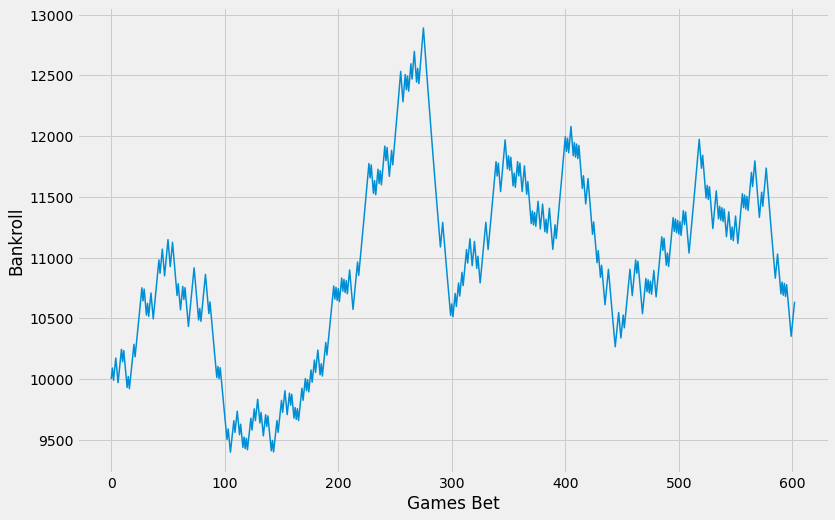

min balance: 9398.111264648023 
max balance: 12891.521023761255 
final balance: 10530.622201132463 
win percentage 53.06999999999999


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18092,2015-11-05,POR,MEM,115,96,19,4.5,1.0,103.370948,95.640754,7.730194,1,1,12.230194,10000.000000,100.000000,10090.909091
1,18094,2015-11-06,SAC,HOU,110,116,-6,4.5,0.0,109.210189,106.233007,2.977182,1,0,7.477182,10090.909091,100.909091,9990.000000
2,18099,2015-11-07,UTA,MEM,89,79,10,-2.5,1.0,99.770023,89.744087,10.025936,1,1,7.525936,9990.000000,99.900000,10080.818182
3,18102,2015-11-07,SAC,GSW,94,103,-9,14.0,1.0,108.469147,114.271634,-5.802486,1,1,8.197514,10080.818182,100.808182,10172.461983
4,18129,2015-11-11,POR,SAS,101,113,-12,6.5,0.0,101.962608,100.957084,1.005524,1,0,7.505524,10172.461983,101.724620,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,24066,2020-09-10,HOU,LAL,100,110,-10,5.5,0.0,110.558399,105.609099,4.949300,1,0,10.449300,10456.654583,104.566546,10352.088038
599,24070,2020-09-13,DEN,LAC,111,98,13,8.5,1.0,107.329021,105.167032,2.161989,1,1,10.661989,10352.088038,103.520880,10446.197929
600,24085,2020-10-04,MIA,LAL,115,104,11,9.5,1.0,108.900475,107.381815,1.518660,1,1,11.018660,10446.197929,104.461979,10541.163364
601,24086,2020-10-06,MIA,LAL,96,102,-6,7.5,1.0,109.083038,107.996385,1.086653,1,1,8.586653,10541.163364,105.411634,10636.992122


In [154]:
select_bets_lgbr, best_thresholds_lgbr = find_optimal_threshold(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

In [157]:
best_lgbr = lgbr_bs.best_estimator_
best_lgbr.fit(features, scores)

[LightGBM] [Warning] feature_fraction is set=0.09266836113965404, colsample_bytree=0.7603922042290461 will be ignored. Current value: feature_fraction=0.09266836113965404
[LightGBM] [Warning] num_leaves is set=31, num_leaf=31 will be ignored. Current value: num_leaves=31


MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.7603922042290461,
                                             feature_fraction=0.09266836113965404,
                                             max_depth=3, min_child_weight=3,
                                             num_leaf=31,
                                             objective='regression',
                                             reg_alpha=10, reg_lambda=10,
                                             subsample_freq=1))

In [160]:
filename = '../models/best_lgbr.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_lgbr, file)
    




### Stacking Regressor

In [70]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])
ada_lasso = MultiOutputRegressor(AdaBoostRegressor(base_estimator = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])))

ada = MultiOutputRegressor(AdaBoostRegressor())

best_rf = RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)

lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

estimators = [lasso_pipeline, ada_lasso, ada, best_rf, lr_pipeline]

stacked_clf = MultiOutputRegressor(StackingRegressor(estimators=estimators, final_estimator = LinearRegression(), verbose=2, n_jobs=-1))

stacked_clf.fit(X_train, scores_train)


stacked_preds = stacked_clf.predict(X_test)



TypeError: zip argument #2 must support iteration

In [ ]:
select_bets_stacked, best_thresholds_stacked = find_optimal_threshold(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

In [288]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.44s/it]


In [8]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [9]:
from src.models.model_preparation import avg_data_for_model
from src.data.make_team_dataset import create_matchups, prep_for_aggregation
from src.features.build_team_features import add_percentage_features, add_rest_days

df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = avg_data_for_model(df1)
df1 = add_percentage_features(df1)
df1 = add_rest_days(df1)

new_cols = []
for col in df1.columns:
    if col.endswith('team'):
        col = col[:-5]
    
    new_cols.append(col)
df1.columns = new_cols
# df1 = df1.loc[df1['HOME_GAME'] == 1]
df1.sort_values('GAME_DATE')
df1

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM,OREB_PCT,DREB_PCT,REB_PCT,TS_PCT,EFG_PCT,AST_RATIO,TOV_PCT,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
0,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,1,109,-7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000008,2020-12-25,LAL vs. DAL,1,138,23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000040,2020-12-27,LAL vs. MIN,1,127,36,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000045,2020-12-28,LAL vs. POR,1,107,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000060,2020-12-30,LAL @ SAS,0,121,14,1,240.0,0.6,32.2,55.0,13.0,31.2,17.0,22.2,8.6,37.8,46.4,26.4,5.8,5.6,17.0,20.0,120.4,11.6,115.52,117.52,105.04,106.22,10.48,11.30,102.4,0.5590,14.2,17.6,14.6,49.2,15.2,16.0,9.8,2.4,0.218274,0.807692,0.538283,0.660928,0.599768,25.781250,15.048509,240.0,0.4,29.4,56.2,11.8,35.4,14.6,19.4,9.0,30.8,39.8,23.6,10.2,4.4,12.8,21.8,108.8,-11.6,105.04,106.22,115.52,117.52,-10.48,-11.30,102.6,0.4410,8.8,15.0,18.8,49.2,14.4,14.0,8.2,3.0,0.192308,0.781726,0.461717,0.567447,0.514192,23.001949,11.333853,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2020-21,22020,1610612760,OKC,Oklahoma City Thunder,22000586,2021-03-13,OKC vs. NYK,1,97,-22,0,240.0,0.5,24.1,45.9,12.9,38.3,14.1,19.0,7.8,35.6,43.4,21.8,5.8,3.9,14.3,19.0,101.0,-4.7,102.09,103.45,106.94,107.98,-4.84,-4.52,97.7,0.4555,3.9,5.3,14.2,43.4,11.4,12.0,9.8,2.6,0.170678,0.787611,0.477448,0.571396,0.516033,22.313204,13.381995,240.0,0.5,27.6,51.8,11.7,34.5,15.4,20.4,9.6,37.9,47.5,23.0,7.6,4.7,13.2,17.6,105.7,4.7,106.94,107.9

In [37]:
prev_season_final_elo = {}
for team in full_df['TEAM_ABBREVIATION'].unique():
    team_df = full_df.loc[full_df['TEAM_ABBREVIATION'] == team].sort_values('GAME_DATE').reset_index(drop=True)
    final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'HOU': 1592.8061316925175,
 'POR': 1494.4500286882749,
 'CHA': 1336.0857158848346,
 'PHX': 1467.1433716661513,
 'MIN': 1334.876543008371,
 'LAC': 1585.2027933871393,
 'DAL': 1489.78112835511,
 'MIL': 1691.6267378675223,
 'BKN': 1446.9855523900742,
 'CHI': 1310.9827810845577,
 'IND': 1568.7574184503267,
 'PHI': 1590.9391782685086,
 'NYK': 1295.8334651599992,
 'CLE': 1254.4277334029882,
 'SAS': 1511.9475234777801,
 'GSW': 1296.509281737069,
 'SAC': 1463.3998161359382,
 'DET': 1325.3640523411293,
 'DEN': 1596.5965930440295,
 'LAL': 1622.585614793648,
 'OKC': 1595.2859561422845,
 'ATL': 1338.5855784973007,
 'MIA': 1634.7362170560314,
 'BOS': 1682.7827251651756,
 'UTA': 1558.6788333810905,
 'TOR': 1643.0408253093453,
 'WAS': 1368.8271472091822,
 'MEM': 1535.502184890209,
 'ORL': 1441.2580581243433,
 'NOP': 1478.3966107929218}

In [42]:
full_df.loc[full_df['TEAM_ABBREVIATION'] == 'MIA'].sort_values('GAME_DATE')

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
31,2000-01,22000,1610612748,MIA,Miami Heat,20000103,2000-11-14,MIA vs. CHA,1,89,86,3,1,240.000000,0.500000,25.333333,59.000000,6.000000,15.000000,18.333333,23.833333,9.666667,29.666667,39.333333,17.666667,9.666667,5.666667,17.333333,24.666667,87.000000,5.166667,94.516667,95.666667,88.350000,90.333333,6.183333,5.366667,91.0,0.544000,20.500000,9.500000,18.666667,29.333333,12.333333,12.000000,4.833333,1.166667,0.240664,0.723577,0.484600,0.548942,0.463964,19.413919,17.023506,240.000000,0.500000,27.500000,59.666667,3.500000,14.500000,16.333333,24.166667,11.333333,30.500000,41.833333,16.833333,7.500000,6.833333,19.666667,22.833333,81.833333,-5.166667,88.350000,90.333333,94.516667,95.666667,-6.183333,-5.366667,91.000000,0.456000,14.166667,8.000000,16.666667,39.833333,13.000000,13.500000,3.166667,0.0,0.276423,0.759336,0.515400,0.514783,0.441573,18.498168,18.825782,3.0,240.0,0.571429,26.857143,61.285714,3.714286,11.571429,23.857143,32.714286,12.142857,29.571429,41.714286,19.428571,7.714286,6.142857,16.428571,22.571429,88.714286,0.714286,96.785714,98.257143,95.542857,97.80,1.242857,0.442857,90.142857,0.527143,18.428571,9.571429,16.857143,34.571429,16.0,9.857143,3.142857,0.428571,0.307971,0.741935,0.526126,0.554088,0.445098,21.553090,15.845459,240.0,0.428571,27.285714,64.857143,4.428571,11.857143,20.142857,25.0,10.285714,27.285714,37.571429,18.285714,7.571429,3.714286,14.857143,26.571429,88.0

In [39]:
teams = []
elos = []
for key in prev_season_final_elo:
    teams.append(key)
    elos.append(prev_season_final_elo[key])

final_elo_2019 = pd.DataFrame({'team':teams, 'final_elo':elos})
final_elo_2019.sort_values('final_elo')

,team,final_elo
13,CLE,1254.427733
12,NYK,1295.833465
15,GSW,1296.509282
9,CHI,1310.982781
17,DET,1325.364052
4,MIN,1334.876543
2,CHA,1336.085716
21,ATL,1338.585578
26,WAS,1368.827147
28,ORL,1441.258058


In [298]:
final_elo_2019.to_csv("")

,team,elo
0,HOU,1263.462250
1,POR,1535.402671
2,CHA,1479.430990
3,PHX,1660.009154
4,MIN,1301.588505
5,LAC,1628.749887
6,DAL,1546.918850
7,MIL,1629.537059
8,BKN,1619.430321
9,CHI,1494.807283


In [43]:
# Add ELO ratings

def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE']
        away_score = home_score - row['point_diff']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, prev_season_final_elo)


progress:: 625it [00:00, 710.25it/s]


In [44]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1671.7187713553164),
 ('LAL', 1652.555008933853),
 ('MIL', 1628.40946032107),
 ('DEN', 1612.2903865258656),
 ('PHX', 1606.659147397523),
 ('PHI', 1597.991965856332),
 ('LAC', 1597.5641982977713),
 ('BKN', 1570.1880824228897),
 ('DAL', 1550.4524868549358),
 ('BOS', 1545.7238943287057),
 ('MIA', 1527.06725017937),
 ('MEM', 1517.8962946961042),
 ('IND', 1514.500643540605),
 ('NOP', 1512.822802097341),
 ('TOR', 1502.0609651001698),
 ('ATL', 1482.29598613444),
 ('SAS', 1481.3603607362284),
 ('POR', 1480.9821180113045),
 ('GSW', 1469.0965991308492),
 ('CHI', 1467.5231008529584),
 ('NYK', 1445.3510801049626),
 ('CHA', 1435.974721630062),
 ('OKC', 1400.071868062168),
 ('SAC', 1398.595386372406),
 ('DET', 1369.4978748366607),
 ('WAS', 1361.5075413326683),
 ('CLE', 1343.049484798929),
 ('ORL', 1342.2856550837328),
 ('HOU', 1325.0476495171022),
 ('MIN', 1292.005913540565)]

In [46]:
def create_matchup_row(df, away_team, home_team):
    home_team = df.loc[df['TEAM_ABBREVIATION'] == home_team].sort_values('GAME_DATE')
    away_team = df.loc[df['TEAM_ABBREVIATION'] == away_team].sort_values('GAME_DATE')
    
    home_cols = ["HOME_" + col for col in home_team.columns]
    away_cols = ["AWAY_" + col for col in away_team.columns]    
    home_cols.extend(away_cols)

    home_last = home_team.iloc[-1].values.reshape(1, -1)
    away_last = away_team.iloc[-1].values.reshape(1, -1)
    
    matchup_row = np.concatenate([home_last, away_last], axis=1)
    
    df_row = pd.DataFrame(matchup_row, columns = home_cols)
    
    # Add ELO Rating
    home_team_abbr = df_row['HOME_TEAM_ABBREVIATION'].values[0]
    away_team_abbr = df_row['AWAY_TEAM_ABBREVIATION'].values[0]
    df_row['home_rating_i'] = elo_ratings_dic[home_team_abbr]
    df_row['away_rating_i'] = elo_ratings_dic[away_team_abbr]
    df_row['home_elo_pred'] = elo_prediction(df_row['home_rating_i'].values[0], df_row['away_rating_i'].values[0])
    df_row['elo_MOV_pred'] =  round((df_row['home_rating_i'].values[0]+100 - df_row['away_rating_i'].values[0])/28, 2)
        
    return df_row



In [128]:
create_matchup_row(df1, 'SAC', 'CHA')

,HOME_SEASON_YEAR,HOME_SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,HOME_GAME_ID,HOME_GAME_DATE,HOME_MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_point_diff,HOME_WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_SEASON_YEAR,AWAY_SEASON_ID,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,AWAY_TEAM_NAME,AWAY_GAME_ID,AWAY_GAME_DATE,AWAY_MATCHUP,AWAY_HOME_GAME,AWAY_TEAM_SCORE,AWAY_point_diff,AWAY_WL,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_rating_i,away_rating_i,home_elo_pred,elo_MOV_pred
0,2020-21,22020,1610612766,CHA,Charlotte Hornets,22000588,2021-03-13,CHA vs. TOR,1,114,10,1,240,0.6,27.4,50.7,14.7,36.9,17,20.8,9.7,33.9,43.6,25.9,9.3,4.3,17.8,19.3,115.9,-0.3,110.45,112.52,111.98,113,-1.53,-0.47,103,0.49,4.7,14.4,20.4,48.8,13.4,13.2,11.5,2.5,0.228774,0.788372,0.510539,0.628689,0.564498,25.1456,15.5388,240,0.4,27.7,48.3,15.5,40.4,14.3,18.2,9.1,32.7,41.8,28.7,9.4,4.5,16.3,17.7,116.2,0.3,111.98,113,110.45,112.52,1.53,0.47,103,0.51,6.7,14.8,20.5,47.7,15.1,11.7,12.8,1.9,0.211628,0.771226,0.489461,0.626726,0.574408,27.8641,14.4238,2,2020-21,22020,1610612758,SAC,Sacramento Kings,22000590,2021-03-13,SAC @ ATL,0,106,-15,0,240,0.3,33.6,60.5,11.1,31.9,17.2,23.1,11.6,30.3,41.9,26.6,6.7,3.1,12.1,21,117.7,-4.3,114.38,117.55,120.5,121.79,-6.12,-4.23,100.2,0.4758,7.3,11.1,13.9,59.3,17.7,15.3,7.8,2.6,0.258929,0.753731,0.492941,0.603701,0.543831,26.5469,10.5526,240,0.7,31.4,54.4,13.1,33.3,19.9,25.1,9.9,33.2,43.1,24.2,6.4,5,12.6,19.8,122,4.3,120.5,121.79,114.38,117.55,6.12,4.23,100.3,0.5242,9.3,11.6,15,52.5,14.2,16.4,8.9,3.2,0.246269,0.741071,0.507059,0.654352,0.582098,24.1276,11.3163,2,1472.113153,1376.242533,0.634571,7.0


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,MIL,WAS,2021-03-15,-8.5-110,-8.5-109,-8.5,-8.5,8.5,8.5,8.5,8.5,-8.5,8.5
1,SAC,CHA,2021-03-15,3.5-105,3.5-115,3.0,3.5,-3.5,-3.5,-3.0,-3.5,3,-3.5
2,NYK,BKN,2021-03-15,8.5-110,8.5-111,8.5,8.5,-8.5,-8.5,-8.5,-8.5,8.5,-8.5
3,SAS,DET,2021-03-15,-2-110,-1.5-112,-2.0,-2.0,2.0,1.5,2.0,2.0,-2,2.0
4,IND,DEN,2021-03-15,4.5-110,4.5-107,4.5,4.5,-4.5,-4.5,-4.5,-4.5,4.5,-4.5
5,LAC,DAL,2021-03-15,-2-110,-2-108,-2.0,-2.0,2.0,2.0,2.0,2.0,-2,2.0
6,MEM,PHX,2021-03-15,7-110,7-108,7.5,7.0,-7.0,-7.0,-7.5,-7.0,7,-7.0
7,LAL,GSW,2021-03-15,-1.5-110,-2-105,-1.5,-2.0,1.5,2.0,1.5,2.0,-2-105,1.5


## Make Predictions

In [3]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                  | 0/9 [00:00<?, ?it/s]

Updating 9 Games


progress: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:22<00:00,  2.51s/it]


updating scoring boxscores


progress:   0%|                                                                                  | 0/9 [00:00<?, ?it/s]

Updating 9 Games


progress:   0%|                                                                                  | 0/9 [00:00<?, ?it/s]

updating tracking boxscores
Updating 9 Games


progress: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:22<00:00,  2.53s/it]
progress: 0it [00:00, ?it/s]

Updating lines for 0 days



progress: 0it [00:00, ?it/s]

Updating lines for 0 days


In [83]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,POR,MIA,2021-03-25,2-110,2-110,2.0,2.0,-2.0,-2.0,-2.0,-2.0,2,-2.0
1,WAS,NYK,2021-03-25,3-110,3-110,3.5,3.0,-3.0,-3.0,-3.5,-3.0,3-110,-3.0
2,LAC,SAS,2021-03-25,-6.5-110,-6-113,-6.5,-6.5,6.5,6.0,6.5,6.5,-6.5,6.5
3,GSW,SAC,2021-03-25,2.5-110,2.5-105,2.5,2.5,-2.5,-2.5,-2.5,-2.5,2.5,-2.5
4,PHI,LAL,2021-03-25,-6-105,-5.5-110,-5.5,-5.5,6.0,5.5,5.5,5.5,-5.5,5.5


In [80]:
# Load Saved Models

loaded_lr = pickle.load(open('../models/linreg_team_score_model.pkl', 'rb'))
loaded_lasso = pickle.load(open('../models/best_lasso.pkl', 'rb'))
loaded_rf = pickle.load(open("../models/rf_team_score_model.pkl", 'rb'))
loaded_ada = pickle.load(open("../models/ada_team_score_model.pkl", 'rb'))
loaded_xgb = pickle.load(open('../models/xgb_team_score_model.pkl', 'rb'))
loaded_svr = pickle.load(open('../models/svr_team_score_model.pkl', 'rb'))
loaded_lgb = pickle.load(open('../models/best_lgbr.pkl', 'rb'))  

In [81]:
def make_prediction(df, away_team, home_team):
    matchup_row = create_matchup_row(df, away_team, home_team)
    matchup_row = matchup_row[features.columns.tolist()]
#     scaler = StandardScaler()
#     scaler.fit(features)
#     matchup_row = scaler.transform(matchup_row)
    matchup_row = matchup_row.astype(float) 
    lr_pred = loaded_lr.predict(matchup_row)
    lasso_pred = loaded_lasso.predict(matchup_row)
    rf_pred = loaded_rf.predict(matchup_row)
    ada_pred = loaded_ada.predict(matchup_row)
    xgb_pred = loaded_xgb.predict(matchup_row)
    svr_pred = loaded_svr.predict(matchup_row)
    lgb_pred = loaded_lgb.predict(matchup_row)
    
    return lr_pred, lasso_pred, rf_pred, ada_pred, xgb_pred, svr_pred, lgb_pred


In [84]:
todays_date = datetime.today().strftime('%Y-%m-%d')
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)

df = load_current_season_team_data(season='2020-21')
df = clean_team_data(df)
df = prep_for_aggregation(df)
df = create_matchups(df) 
df = avg_data_for_model(df)
df = add_percentage_features(df)
df = add_rest_days(df)

new_cols = []
for col in df.columns:
    if col.endswith('team'):
        col = col[:-5]
    
    new_cols.append(col)
df.columns = new_cols
df.sort_values('GAME_DATE')

elo_ratings_dic = get_current_elo_ratings(df, prev_season_final_elo)


my_predictions = pd.read_csv('../results/my_predictions.csv')

game_dates = []
away_teams = []
home_teams = []
spreads = []
lr_home, lr_away = [], []
rf_home, rf_away = [], []
lasso_home, lasso_away= [], []
ada_home, ada_away = [], []
xgb_home, xgb_away = [], []
svr_home, svr_away = [], []
lgb_home, lgb_away = [], []

for idx, row in todays_spreads.iterrows():
    game_date = row['game_date']
    away_team = row['away_team']
    home_team = row['home_team']
    spread = row['home_spread_mode']
    lr_pred, lasso_pred, rf_pred, ada_pred, xgb_pred, svr_pred, lgb_pred = make_prediction(df1, away_team, home_team)
    game_dates.append(game_date)
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    lr_home.append(lr_pred[0][0])
    lr_away.append(lr_pred[0][1])
    rf_home.append(rf_pred[0][0])
    rf_away.append(rf_pred[0][1])
    lasso_home.append(lasso_pred[0][0])
    lasso_away.append(lasso_pred[0][1])
    ada_home.append(ada_pred[0][0])
    ada_away.append(ada_pred[0][1])
    xgb_home.append(xgb_pred[0][0])
    xgb_away.append(xgb_pred[0][1])
    svr_home.append(svr_pred[0][0])
    svr_away.append(svr_pred[0][1])
    lgb_home.append(lgb_pred[0][0])
    lgb_away.append(lgb_pred[0][1])

todays_betting_preds = pd.DataFrame({'game_date':game_dates,
                                     'away_team':away_teams,
                                     'home_team':home_teams,
                                     'spread':spreads,
                                     'lr_home':lr_home,
                                     'lr_away':lr_away,
                                     'lasso_home':lasso_home,
                                     'lasso_away':lasso_away,
                                     'rf_home':rf_home,
                                     'rf_away':rf_away,
                                    'ada_home':ada_home,
                                    'ada_away':ada_away,
                                    'xgb_home': xgb_home,
                                    'xgb_away': xgb_away,
                                    'svr_home': svr_home,
                                    'svr_away': svr_away,
                                    'lgb_home': lgb_home,
                                    'lgb_away': lgb_away})

todays_betting_preds['lr_diff'] = todays_betting_preds['lr_home'] - todays_betting_preds['lr_away']
todays_betting_preds['lasso_diff'] = todays_betting_preds['lasso_home'] - todays_betting_preds['rf_away']
todays_betting_preds['rf_diff'] = todays_betting_preds['rf_home'] - todays_betting_preds['rf_away']
todays_betting_preds['ada_diff'] = todays_betting_preds['ada_home'] - todays_betting_preds['ada_away']
todays_betting_preds['xgb_diff'] = todays_betting_preds['xgb_home'] - todays_betting_preds['xgb_away']
todays_betting_preds['svr_diff'] = todays_betting_preds['svr_home'] - todays_betting_preds['svr_away']
todays_betting_preds['lgb_diff'] = todays_betting_preds['lgb_home'] - todays_betting_preds['lgb_away']


todays_betting_preds['lr_confidence'] = todays_betting_preds['lr_diff'] + todays_betting_preds['spread']
todays_betting_preds['lasso_confidence'] = todays_betting_preds['lasso_diff'] + todays_betting_preds['spread']
todays_betting_preds['rf_confidence'] = todays_betting_preds['rf_diff'] + todays_betting_preds['spread']
todays_betting_preds['ada_confidence'] = todays_betting_preds['ada_diff'] + todays_betting_preds['spread']
todays_betting_preds['xgb_confidence'] = todays_betting_preds['xgb_diff'] + todays_betting_preds['spread']
todays_betting_preds['svr_confidence'] = todays_betting_preds['svr_diff'] + todays_betting_preds['spread']
todays_betting_preds['lgb_confidence'] = todays_betting_preds['lgb_diff'] + todays_betting_preds['spread']


updated_predictions = pd.concat([my_predictions, todays_betting_preds])
updated_predictions.to_csv('../results/my_predictions.csv', index=False)

todays_betting_preds


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
progress:: 650it [00:00, 702.72it/s]


,game_date,away_team,home_team,spread,lr_home,lr_away,lasso_home,lasso_away,rf_home,rf_away,ada_home,ada_away,xgb_home,xgb_away,svr_home,svr_away,lgb_home,lgb_away,lr_diff,lasso_diff,rf_diff,ada_diff,xgb_diff,svr_diff,lgb_diff,lr_confidence,lasso_confidence,rf_confidence,ada_confidence,xgb_confidence,svr_confidence,lgb_confidence
0,2021-03-25,POR,MIA,-2.0,111.369769,110.161988,109.244689,107.945671,106.034924,104.777366,108.274384,106.038899,106.097382,108.580093,111.412424,110.492609,108.699576,108.331642,1.207781,4.467323,1.257558,2.235486,-2.482712,0.919814,0.367934,-0.792219,2.467323,-0.742442,0.235486,-4.482712,-1.080186,-1.632066
1,2021-03-25,WAS,NYK,-3.0,113.126360,107.778199,114.314149,108.110101,112.215320,107.073733,108.971898,109.286598,111.023773,108.196411,113.124082,108.104592,112.620818,106.925459,5.348162,7.240417,5.141587,-0.314700,2.827362,5.019490,5.695359,2.348162,4.240417,2.141587,-3.314700,-0.172638,2.019490,2.695359
2,2021-03-25,LAC,SAS,6.5,106.700823,112.149293,107.555982,110.547915,107.963337,110.644389,110.737366,108.556245,107.913849,110.182281,106.285468,111.632018,107.169703,111.743442,-5.448469,-3.088407,-2.681052,2.181121,-2.268433,-5.346550,-4.573739,1.051531,3.411593,3.818948,8.681121,4.231567,1.153450,1.926261
3,2021-03-25,GSW,SAC,-2.5,116.051409,116.255738,115.438177,115.068535,111.846901,112.722125,116.016760,111.419659,115.586464,111.346619,116.106604,116.142448,113.957009,112.279287,-0.204329,2.716052,-0.875224,4.597101,4.239845,-0.035844,1.677722,-2.704329,0.216052,-3.375224,2.097101,1.739845,-2.535844,-0.822278
4,2021-03-25,PHI,LAL,5.5,112.159808,111.256714,112.166387,111.015473,112.093175,109.129113,114.265089,110.192050,109.586906,107.637390,112.416169,111.383749,113.443758,111.216007,0.903093,3.037274,2.964061,4.073039,1.949516,1.032420,2.227751,6.403093,8.537274,8.464061,9.573039,7.449516,6.532420,7.727751


## Track Results

In [85]:
my_predictions = pd.read_csv('../results/my_predictions.csv')
# my_predictions['Bet Home'] = my_predictions['Bet Home'].astype(int)

In [86]:
spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
spread_df
clean_spread = clean_spread_data(spread_df)

clean_spread

,away_team,home_team,game_date,away_scoreboard,home_scoreboard,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,CHI,MIA,2006-10-31,"22, 37, 21, 28, 108","16, 14, 21, 15, 66",4.5,NaN,4.5,NaN,-4.5,NaN,-4.5,NaN,4.5,-4.5
1,PHX,LAL,2006-10-31,"41, 17, 21, 27, 106","26, 27, 34, 27, 114",-8.5,NaN,-8.0,NaN,8.5,NaN,8.0,NaN,-8.5,8.0
2,NYK,MEM,2006-11-01,"20, 31, 20, 18, 89","25, 21, 14, 29, 89",5.0,NaN,5.0,NaN,-5.0,NaN,-5.0,NaN,5.0,-5.0
3,ATL,PHI,2006-11-01,"14, 21, 23, 17, 75","29, 20, 24, 15, 88",6.0,NaN,5.5,NaN,-6.0,NaN,-5.5,NaN,5.5,-6.0
4,NOP,BOS,2006-11-01,"26, 28, 21, 16, 91","16, 25, 24, 22, 87",3.5,NaN,3.0,NaN,-3.5,NaN,-3.0,NaN,3.0,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18352,BOS,MIL,2021-03-24,"30, 29, 27, 33, 119","35, 35, 30, 21, 121",7.0,6.0,7.0,7.0,-7.0,-6.0,-7.0,-7.0,7.0,-7.0
18353,DEN,TOR,2021-03-24,"30, 24, 27, 30, 111","38, 34, 26, 37, 135",-2.0,-1.5,-1.5,-2.0,2.0,1.5,1.5,2.0,-2.0,1.5
18354,ATL,SAC,2021-03-24,"27, 30, 17, 34, 108","29, 28, 28, 25, 110",-3.5,-3.0,-3.0,-3.0,3.5,3.0,3.0,3.0,-3.0,3.0
18355,DAL,MIN,2021-03-24,"30, 26, 32, 40, 128","33, 22, 18, 35, 108",-8.0,-8.0,-8.5,-8.0,8.0,8.0,8.5,8.0,-8.0,8.0


In [88]:
spread_results = clean_spread[['away_team', 'home_team', 'game_date', 'away_scoreboard', 'home_scoreboard', 'home_spread_mode']]

spread_results['home_score'] = spread_results['home_scoreboard'].str.split(',').str[-1].str.strip()
spread_results['home_score'] = spread_results['home_score'].str.replace("'", "").astype(float)

spread_results['away_score'] = spread_results['away_scoreboard'].str.split(',').str[-1].str.strip()
spread_results['away_score'] = spread_results['away_score'].str.replace("'", "").astype(float)

spread_results['point_diff'] = spread_results['home_score'] - spread_results['away_score']
spread_results['home_cover'] = (spread_results['point_diff'] + spread_results['home_spread_mode'] > 0).astype(int)

spread_results = spread_results.loc[spread_results['game_date'] < '2021-03-25']
spread_results


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,away_team,home_team,game_date,away_scoreboard,home_scoreboard,home_spread_mode,home_score,away_score,point_diff,home_cover
0,CHI,MIA,2006-10-31,"22, 37, 21, 28, 108","16, 14, 21, 15, 66",-4.5,66.0,108.0,-42.0,0
1,PHX,LAL,2006-10-31,"41, 17, 21, 27, 106","26, 27, 34, 27, 114",8.0,114.0,106.0,8.0,1
2,NYK,MEM,2006-11-01,"20, 31, 20, 18, 89","25, 21, 14, 29, 89",-5.0,89.0,89.0,0.0,0
3,ATL,PHI,2006-11-01,"14, 21, 23, 17, 75","29, 20, 24, 15, 88",-6.0,88.0,75.0,13.0,1
4,NOP,BOS,2006-11-01,"26, 28, 21, 16, 91","16, 25, 24, 22, 87",-3.5,87.0,91.0,-4.0,0
...,...,...,...,...,...,...,...,...,...,...
18352,BOS,MIL,2021-03-24,"30, 29, 27, 33, 119","35, 35, 30, 21, 121",-7.0,121.0,119.0,2.0,0
18353,DEN,TOR,2021-03-24,"30, 24, 27, 30, 111","38, 34, 26, 37, 135",1.5,135.0,111.0,24.0,1
18354,ATL,SAC,2021-03-24,"27, 30, 17, 34, 108","29, 28, 28, 25, 110",3.0,110.0,108.0,2.0,1
18355,DAL,MIN,2021-03-24,"30, 26, 32, 40, 128","33, 22, 18, 35, 108",8.0,108.0,128.0,-20.0,0


In [89]:
my_predictions['game_date'] = pd.to_datetime(my_predictions['game_date'])
results = pd.merge(my_predictions, spread_results[['away_team', 'home_team', 'game_date', 'home_score', 'away_score', 'point_diff', 'home_cover']],
                  how='left', on=['away_team', 'home_team', 'game_date'])

results['bet_won'] = (results['Bet Home'] == results['home_cover']).astype(int)
results['model_avg_confidence'] = results['Diff Avg'] + results['spread']
test = results[['game_date', 'away_team', 'home_team', 'spread', 'Diff Avg', 'model_avg_confidence', 'Bet Home', 'bet_won']]

In [90]:

for i in range(0,8):
    win_pct = test.loc[abs(test['model_avg_confidence']) >= i, 'bet_won'].mean()
    print("avg_confidence_threshold:", i, "...win_pct:", win_pct)

avg_confidence_threshold: 0 ...win_pct: 0.525
avg_confidence_threshold: 1 ...win_pct: 0.5357142857142857
avg_confidence_threshold: 2 ...win_pct: 0.5294117647058824
avg_confidence_threshold: 3 ...win_pct: 0.5833333333333334
avg_confidence_threshold: 4 ...win_pct: 0.7142857142857143
avg_confidence_threshold: 5 ...win_pct: 0.8
avg_confidence_threshold: 6 ...win_pct: 1.0
avg_confidence_threshold: 7 ...win_pct: 1.0


In [75]:
test

,game_date,away_team,home_team,spread,Diff Avg,model_avg_confidence,Bet Home,bet_won
0,2021-03-14,MEM,OKC,9.5,-4.34,5.16,True,1
1,2021-03-14,UTA,GSW,7.5,-5.56,1.94,True,1
2,2021-03-14,SAS,PHI,-4.5,5.83,1.33,True,1
3,2021-03-14,MIA,ORL,7.5,-6.87,0.63,True,1
4,2021-03-14,CLE,ATL,-5.5,7.50,2.00,True,1
5,2021-03-14,BOS,HOU,11.0,-7.80,3.20,True,0
6,2021-03-14,POR,MIN,5.0,-5.35,-0.35,False,0
7,2021-03-14,TOR,CHI,-3.0,-2.35,-5.35,False,0
8,2021-03-14,LAC,NOP,6.0,-1.90,4.10,True,1
9,2021-03-15,MIL,WAS,8.5,-6.66,1.84,True,0
